In [1]:
import numpy as np

landmarks = np.load("/data2/Datasets/HDTF/cropped_videos_original/WDA_ElijahCummings_000.npy")
landmarks.shape

(6375, 68, 2)

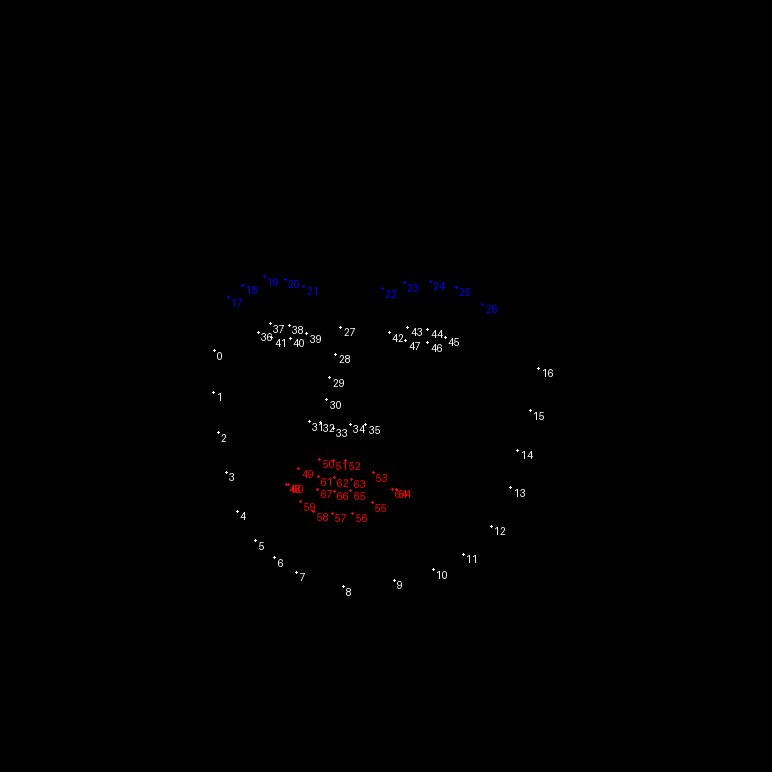

In [2]:
from PIL import Image, ImageDraw, ImageFont


def create_landmarks_image_with_numbers_and_colors(landmarks, image_size=(772, 772), point_size=3, color_ranges=None):
    """
    Creates an image of landmarks on a black background, labels each landmark with its index,
    and colors specified ranges of landmarks differently using PIL.

    Parameters:
    - landmarks (np.array): An array of shape (N, 2) containing facial landmarks.
    - image_size (tuple): The size of the output image (height, width).
    - point_size (int): The diameter of each landmark point in pixels.
    - color_ranges (list of tuples): Each tuple contains (start_index, end_index, color),
                                    where `color` is a string specifying the color.

    Returns:
    - Image object: A PIL Image object with landmarks and their indices plotted.
    """
    # Create a black image
    img = Image.new("RGB", image_size, "black")
    draw = ImageDraw.Draw(img)

    # Font for the landmark numbers
    try:
        # Attempt to use a basic font; adjust the path as needed for your environment
        font = ImageFont.truetype("arial.ttf", size=10)
    except IOError:
        # Fallback to a default PIL font if arial isn't available
        font = ImageFont.load_default()

    # Initialize default color for landmarks
    default_color = "white"

    # Draw each landmark and its index
    for index, (x, y) in enumerate(landmarks):
        # Determine color based on the provided ranges
        landmark_color = default_color
        if color_ranges:
            for start, end, color in color_ranges:
                if start <= index <= end:
                    landmark_color = color
                    break

        # Calculate the square around the point
        top_left = (x - point_size // 2, y - point_size // 2)
        bottom_right = (x + point_size // 2, y + point_size // 2)
        draw.ellipse([top_left, bottom_right], fill=landmark_color)

        # Position the text above the landmark point
        text_position = (x + point_size // 2 + 2, y - point_size // 2)
        draw.text(text_position, str(index), font=font, fill=landmark_color)

    return img


# Example usage:
# landmarks = np.array([[100, 50], [200, 150], [300, 250], [400, 300], [500, 450]])
# color_ranges = [(0, 1, 'red'), (2, 4, 'blue')]
img = create_landmarks_image_with_numbers_and_colors(landmarks[0], color_ranges=((48, 68, "red"), (17, 26, "blue")))
img.show()  # This will display the image

In [29]:
import numpy as np
import cv2


def create_masks_from_landmarks_box(landmark_list, img_shape, nose_index=33, box_expand=0, dtype="uint8"):
    """
    Creates masks for the face covering the area below the nose for multiple frames of landmarks.

    Parameters:
    - landmark_list (np.array): Array of shape (F, 68, 2) containing facial landmarks for multiple frames.
    - img_shape (tuple): Shape of the image (height, width, channels).
    - nose_index (int): Index of the nose landmark in the landmark list.
    - box_expand (int): Number of pixels to expand the bounding box outward.
    - dtype (str): Data type of the mask.

    Returns:
    - np.array: An array of masks of shape (F, height, width) for each frame.
    """
    height, width = img_shape[:2]
    num_frames = landmark_list.shape[0]

    # Initialize the masks array
    masks = np.zeros((num_frames, height, width), dtype=dtype)

    if 0 <= box_expand < 1:
        box_expand = int(box_expand * width)

    for i in range(num_frames):
        # Get the landmarks for the current frame
        landmarks = landmark_list[i]

        # Get the y-coordinate of the nose landmark
        nose_point_h = landmarks[nose_index, 1]
        cut_h = nose_point_h

        # Find the leftmost and rightmost landmarks
        far_left_index = np.argmin(landmarks[:, 0])
        far_right_index = np.argmax(landmarks[:, 0])

        # Define the points for the mask contour
        left_up_point = np.array([landmarks[far_left_index][0] - box_expand, cut_h], dtype=np.int32)
        left_down_point = np.array([landmarks[far_left_index][0] - box_expand, height], dtype=np.int32)
        right_up_point = np.array([landmarks[far_right_index][0] + box_expand, cut_h], dtype=np.int32)
        right_down_point = np.array([landmarks[far_right_index][0] + box_expand, height], dtype=np.int32)

        # Define the contour
        contour = np.array([[left_up_point, left_down_point, right_down_point, right_up_point]])

        # Draw the contour on the mask
        cv2.drawContours(masks[i], [contour], -1, color=(1), thickness=cv2.FILLED)

    return masks


# Example usage:
# landmarks_batch = np.random.randint(100, 300, (10, 68, 2))  # Example with 10 batches of 68 landmarks
# image_height = 400  # Define the height of the image
# image_width = 300  # Define the width of the image
print(landmarks.shape)
masks = create_masks_from_landmarks_box(landmarks, (772, 772), box_expand=10)
print(masks.shape)  # This will show (10, 400, 300) confirming the mask sizes

# Interpolating the masks to target size
import torchvision
import torch

masks = (
    torch.nn.functional.interpolate(
        torch.tensor(masks).squeeze().unsqueeze(1).float(), size=(512, 512), mode="nearest"
    )
    .squeeze(1)
    .numpy()
)
masks.shape

(6375, 68, 2)
(6375, 772, 772)


(6375, 512, 512)

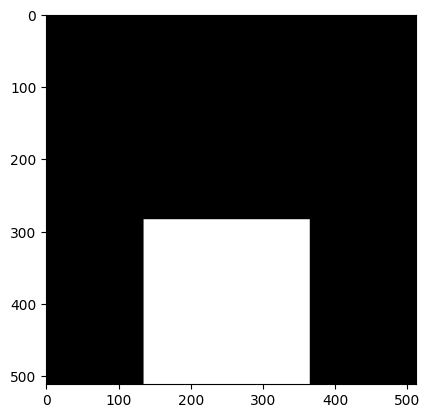

In [30]:
# To visualize one of the masks
import matplotlib.pyplot as plt

plt.imshow(masks[0], cmap="gray")
plt.show()

(6375, 772, 772)


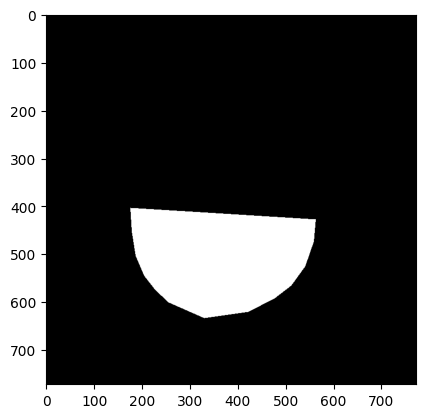

In [34]:
import numpy as np
from PIL import Image, ImageDraw


def expand_polygon(polygon, expand_size):
    """
    Expands the polygon outward by a specified number of pixels.

    Parameters:
    - polygon (list of tuples): The polygon points as (x, y).
    - expand_size (int): The number of pixels to expand the polygon outward.

    Returns:
    - expanded_polygon (list of tuples): The expanded polygon points as (x, y).
    """
    if expand_size == 0:
        return polygon

    # Calculate centroid of the polygon
    centroid_x = sum([point[0] for point in polygon]) / len(polygon)
    centroid_y = sum([point[1] for point in polygon]) / len(polygon)

    # Expand each point outward from the centroid
    expanded_polygon = []
    for x, y in polygon:
        vector_x = x - centroid_x
        vector_y = y - centroid_y
        length = np.sqrt(vector_x**2 + vector_y**2)
        if length == 0:
            expanded_polygon.append((x, y))
        else:
            new_x = x + expand_size * (vector_x / length)
            new_y = y + expand_size * (vector_y / length)
            expanded_polygon.append((int(new_x), int(new_y)))

    return expanded_polygon


def create_face_mask_from_landmarks(landmarks_batch, image_height, image_width, mask_expand=0):
    """
    Creates a batch of masks where each mask covers the face region using landmarks.

    Parameters:
    - landmarks_batch (np.array): An array of shape (B, 68, 2) containing facial landmarks for multiple samples.
    - image_height (int): The height of the image for which masks are created.
    - image_width (int): The width of the image for which masks are created.
    - mask_expand (int): The number of pixels to expand the mask outward.

    Returns:
    - np.array: An array of masks of shape (B, image_height, image_width) for each batch.
    """
    # Initialize an array to hold all masks
    masks = np.zeros((landmarks_batch.shape[0], image_height, image_width), dtype=np.uint8)

    if abs(mask_expand) < 1 and abs(mask_expand) > 0:
        mask_expand = int(mask_expand * image_height)

    for i, landmarks in enumerate(landmarks_batch):
        # Create a blank image for each mask
        mask = Image.new("L", (image_width, image_height), 0)
        draw = ImageDraw.Draw(mask)

        # Extract relevant landmarks for the face
        jawline_landmarks = landmarks[2:15]  # Jawline
        # upper_face_landmarks = landmarks[17:27]  # Eyebrows and top of nose bridge

        # Combine landmarks to form a polygon around the face
        # face_polygon = np.concatenate((jawline_landmarks, upper_face_landmarks[::-1]), axis=0)
        face_polygon = jawline_landmarks

        # Convert landmarks to a list of tuples
        face_polygon = [(int(x), int(y)) for x, y in face_polygon]

        # Expand the polygon if necessary
        expanded_polygon = expand_polygon(face_polygon, mask_expand)

        # Draw the polygon and fill it
        draw.polygon(expanded_polygon, outline=1, fill=1)

        # Convert mask to numpy array and add it to the batch of masks
        masks[i] = np.array(mask)

    return masks


# Example usage:
landmarks_batch = np.random.randint(100, 300, (10, 68, 2))  # Example with 10 batches of 68 landmarks
image_height = 772  # Define the height of the image
image_width = 772  # Define the width of the image
masks = create_face_mask_from_landmarks(landmarks, image_height, image_width, mask_expand=0.1)
print(masks.shape)  # This will show (10, 400, 300) confirming the mask sizes
# masks = (
#     torch.nn.functional.interpolate(torch.tensor(masks).unsqueeze(1).float(), size=(512, 512), mode="nearest")
#     .squeeze(1)
#     .numpy()
# )
# To visualize one of the masks
import matplotlib.pyplot as plt

plt.imshow(masks[0], cmap="gray")
plt.show()

In [14]:
from torchvision.io import read_video

video, audio, info = read_video("/data2/Datasets/HDTF/cropped_videos_original/WDA_ElijahCummings_000.mp4")
video.shape

/vol/paramonos2/projects/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([6375, 772, 772, 3])

In [15]:
from torchvision.transforms import Resize

resize = Resize((512, 512))
video = resize(video[:15].permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
video.shape

/vol/paramonos2/projects/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([15, 512, 512, 3])

In [6]:
def scale_landmarks(landmarks, original_size, target_size):
    """
    Scale landmarks from original size to target size.

    Parameters:
    - landmarks (np.array): An array of shape (N, 2) containing facial landmarks.
    - original_size (tuple): The size (height, width) for which the landmarks are currently scaled.
    - target_size (tuple): The size (height, width) to which landmarks should be scaled.

    Returns:
    - scaled_landmarks (np.array): Scaled landmarks.
    """
    scale_y = target_size[0] / original_size[0]
    scale_x = target_size[1] / original_size[1]
    scaled_landmarks = landmarks * np.array([scale_x, scale_y])
    return scaled_landmarks.astype(int)


def create_landmarks_image(landmarks, original_size=(772, 772), target_size=(772, 772), point_size=3):
    """
    Creates an image of landmarks on a black background using efficient NumPy operations.

    Parameters:
    - landmarks (np.array): An array of shape (68, 2) containing facial landmarks.
    - image_size (tuple): The size of the output image (height, width).
    - point_size (int): The radius of each landmark point in pixels.

    Returns:
    - img (np.array): An image array with landmarks plotted.
    """
    img = np.zeros(target_size, dtype=np.uint8)

    landmarks = scale_landmarks(landmarks, original_size, target_size)

    # Ensure the landmarks are in bounds and integer
    landmarks = np.clip(landmarks, [0, 0], [target_size[1] - 1, target_size[0] - 1]).astype(int)

    # Get x and y coordinates from landmarks
    x, y = landmarks[:, 0], landmarks[:, 1]

    # Define a grid offset based on point_size around each landmark
    offset = np.arange(-point_size // 2, point_size // 2 + 1)
    grid_x, grid_y = np.meshgrid(offset, offset, indexing="ij")

    # Calculate the full set of x and y coordinates for the points
    full_x = x[:, np.newaxis, np.newaxis] + grid_x[np.newaxis, :, :]
    full_y = y[:, np.newaxis, np.newaxis] + grid_y[np.newaxis, :, :]

    # Clip the coordinates to stay within image boundaries
    full_x = np.clip(full_x, 0, target_size[1] - 1)
    full_y = np.clip(full_y, 0, target_size[0] - 1)

    # Flatten the arrays to use them as indices
    full_x = full_x.ravel()
    full_y = full_y.ravel()

    # Set the points in the image
    img[full_y, full_x] = 255

    return np.stack([img] * 3, axis=0)


landmarks_image = create_landmarks_image(landmarks[0], target_size=(224, 224), point_size=2)

In [8]:
from PIL import Image

landmarks_image_rescaled = (landmarks_image.transpose(1, 2, 0) / 255.0) * 2 - 1
landmarks_image_rescaled = np.clip(landmarks_image_rescaled, -1, 1)
landmarks_image_rescaled = ((landmarks_image_rescaled + 1) / 2 * 255).astype(np.uint8)

# Display the the landmarks with number on landmarks
img = Image.fromarray(landmarks_image_rescaled)

(512, 512, 3) uint8


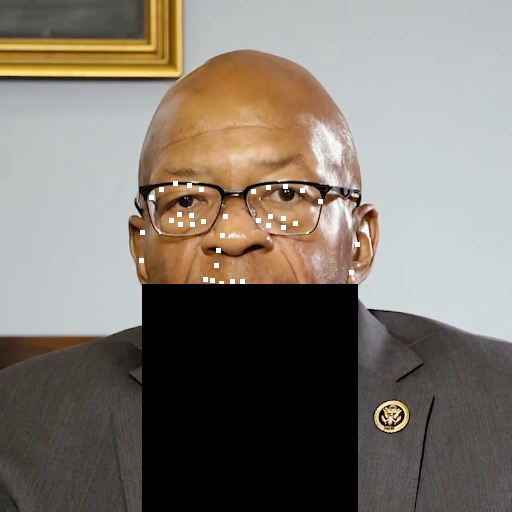

(512, 512, 3) uint8


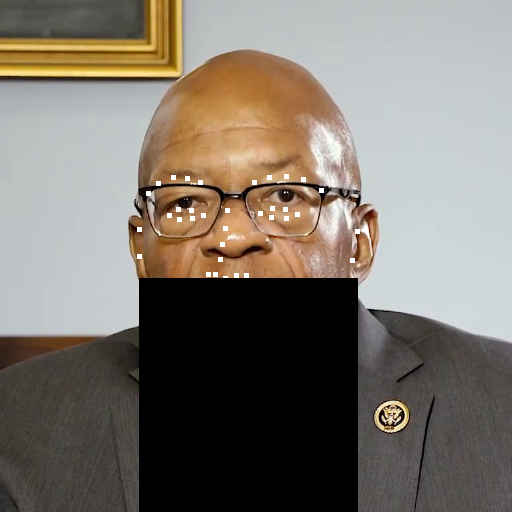

(512, 512, 3) uint8


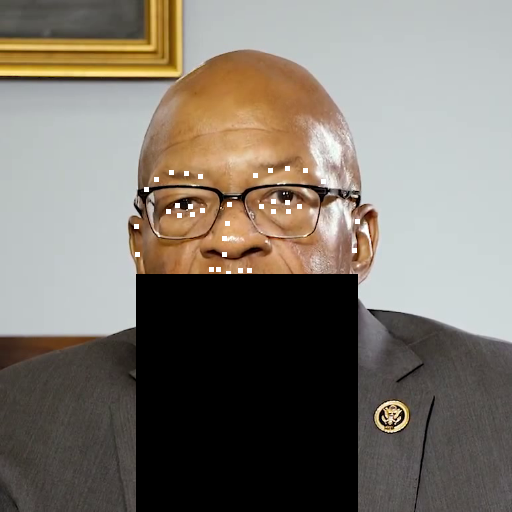

(512, 512, 3) uint8


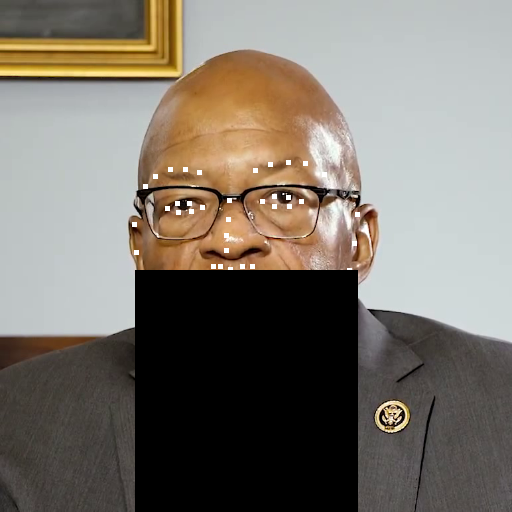

(512, 512, 3) uint8


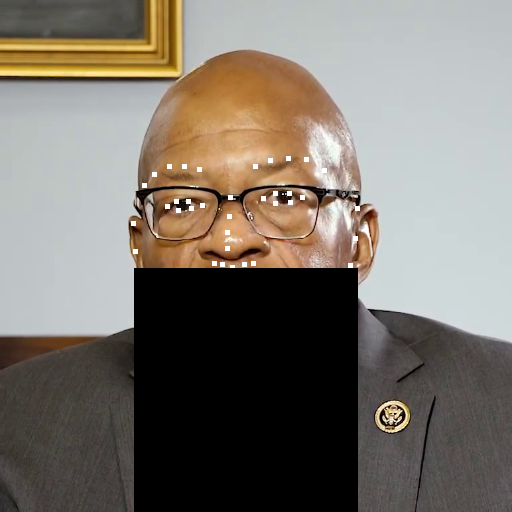

(512, 512, 3) uint8


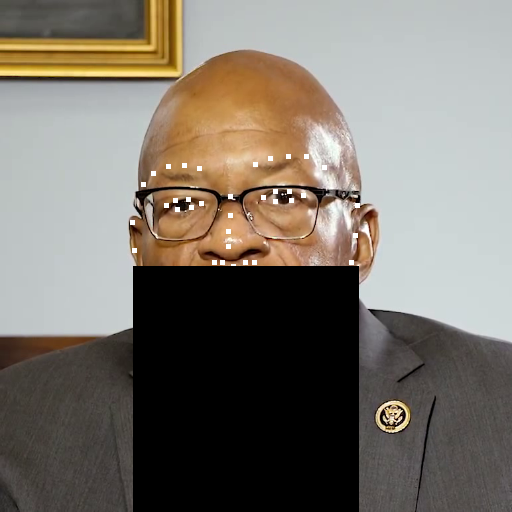

(512, 512, 3) uint8


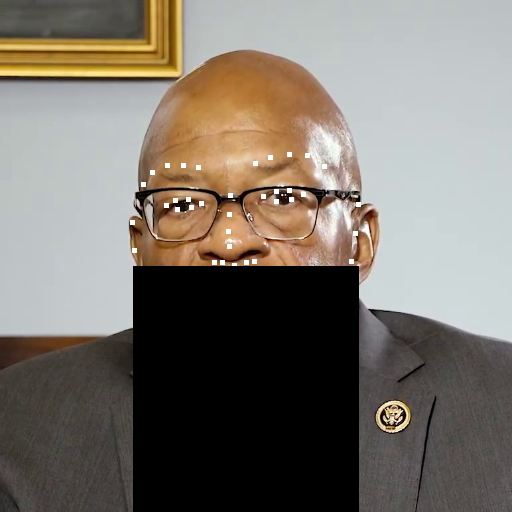

(512, 512, 3) uint8


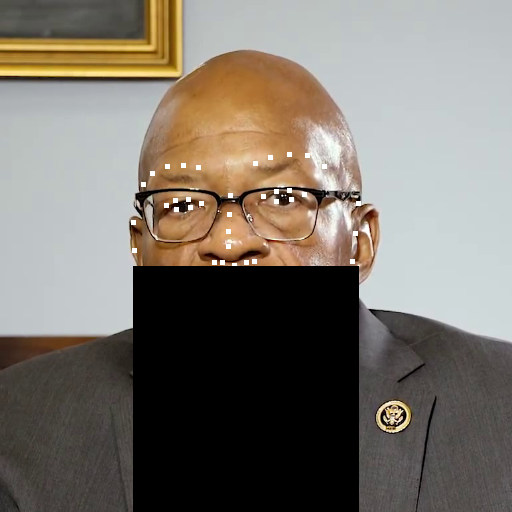

(512, 512, 3) uint8


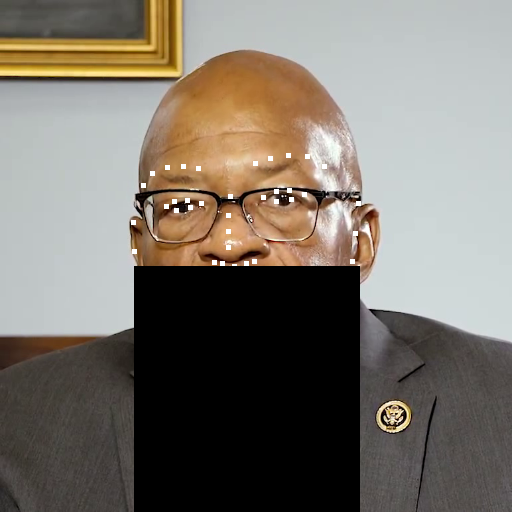

(512, 512, 3) uint8


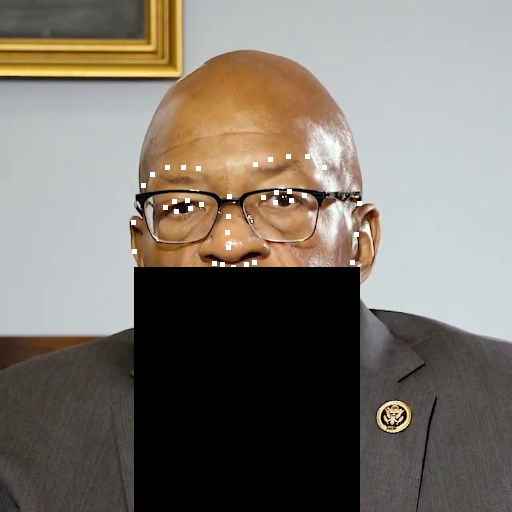

In [16]:
def scale_landmarks(landmarks, original_size, target_size):
    """
    Scale landmarks from original size to target size.

    Parameters:
    - landmarks (np.array): An array of shape (N, 2) containing facial landmarks.
    - original_size (tuple): The size (height, width) for which the landmarks are currently scaled.
    - target_size (tuple): The size (height, width) to which landmarks should be scaled.

    Returns:
    - scaled_landmarks (np.array): Scaled landmarks.
    """
    scale_y = target_size[0] / original_size[0]
    scale_x = target_size[1] / original_size[1]
    scaled_landmarks = landmarks * np.array([scale_x, scale_y])
    return scaled_landmarks.astype(int)


def create_landmarks_image(landmarks, original_size=(772, 772), target_size=(772, 772), point_size=3):
    """
    Creates an image of landmarks on a black background using efficient NumPy operations.

    Parameters:
    - landmarks (np.array): An array of shape (68, 2) containing facial landmarks.
    - image_size (tuple): The size of the output image (height, width).
    - point_size (int): The radius of each landmark point in pixels.

    Returns:
    - img (np.array): An image array with landmarks plotted.
    """
    img = np.zeros(target_size, dtype=np.uint8)

    scaled_landmarks = scale_landmarks(landmarks, original_size, target_size)

    # Ensure the landmarks are in bounds and integer
    landmarks = np.clip(scaled_landmarks, [0, 0], [target_size[1] - 1, target_size[0] - 1]).astype(int)

    # Get x and y coordinates from landmarks
    x, y = landmarks[:, 0], landmarks[:, 1]

    # Define a grid offset based on point_size around each landmark
    offset = np.arange(-point_size // 2, point_size // 2 + 1)
    grid_x, grid_y = np.meshgrid(offset, offset, indexing="ij")

    # Calculate the full set of x and y coordinates for the points
    full_x = x[:, np.newaxis, np.newaxis] + grid_x[np.newaxis, :, :]
    full_y = y[:, np.newaxis, np.newaxis] + grid_y[np.newaxis, :, :]

    # Clip the coordinates to stay within image boundaries
    full_x = np.clip(full_x, 0, target_size[1] - 1)
    full_y = np.clip(full_y, 0, target_size[0] - 1)

    # Flatten the arrays to use them as indices
    full_x = full_x.ravel()
    full_y = full_y.ravel()

    # Set the points in the image
    img[full_y, full_x] = 255

    return np.stack([img] * 3, axis=-1)


def overlay_landmarks_on_tensor(original_tensor, landmarks, point_size=3):
    """
    Overlay landmarks on an existing image tensor.

    Parameters:
    - original_tensor (np.array): Original image tensor of shape (772, 772, 3).
    - landmarks (np.array): An array of shape (68, 2) containing facial landmarks.
    - point_size (int): Diameter of each landmark point.

    Returns:
    - overlaid_image (np.array): Image tensor with landmarks overlaid.
    """
    landmarks_image = create_landmarks_image(
        landmarks, target_size=(original_tensor.shape[1], original_tensor.shape[0]), point_size=point_size
    )
    landmarks_array = np.array(landmarks_image)

    # Overlay the landmarks on the original image
    overlaid_image = np.maximum(original_tensor, landmarks_array)
    return overlaid_image


offset = 0
for i in range(10):
    overlayed = overlay_landmarks_on_tensor(video[offset + i].numpy(), landmarks[offset + i], point_size=4) * (
        1 - masks[offset + i, :, :, None]
    ).astype(np.uint8)
    print(overlayed.shape, overlayed.dtype)
    display(Image.fromarray(overlayed))